<a href="https://colab.research.google.com/github/EnisSah/fastai_imdb_classification.ipynb/blob/master/11_fastai_imdb_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from fastai.basics import *
from fastai.gen_doc.nbdoc import *

In [4]:
import fastai
from fastai.version import __version__
print(__version__)

1.0.61


## Text

Next application is text, so let's start by importing everything we'll need.

In [5]:
from fastai.text import *

### Language modelling

First we'll fine-tune a pretrained language model on our subset of imdb.

In [6]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [7]:
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_by_rand_pct()
                   .label_for_lm()  # Language model does not need labels
                   .databunch())
data_lm.save()

`data.show_batch()` will work here as well. For a language model, it shows us the beginning of each sequence of text along the batch dimension (the target being to guess the next word).

In [8]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"cast does an excellent job with the script . \n \n xxmaj but it is hard to watch , because there is no good end to a situation like the one presented . xxmaj it is now xxunk to blame the xxmaj british for setting xxmaj hindus and xxmaj muslims against each other , and then xxunk xxunk them into two countries . xxmaj there is some merit in"
1,"even turn in a performance , all he proved was , he knows how to use four letter words ! xxmaj that 's what h won the award for ! xxmaj take away the language and i bet he was almost playing himself ! i liked "" xxmaj xxunk xxmaj park "" , i really did , but why 7 nominations ? xxmaj and how on xxmaj earth could they"
2,"gone to is interrupted by a crisis in which all three xxmaj enterprise crew members find themselves unexpectedly xxunk into different xxunk of the planet 's past . xxmaj kirk finds himself in a time period resembling 17th xxmaj century xxmaj england , while xxmaj xxunk and mccoy are xxunk in a xxunk , frozen waste . \n \n xxmaj the xxunk between the two stories , and the"
3,"of xxmaj mankind "" . xxmaj he encounters a curate xxunk with the xxmaj victorian xxunk of a much too precious and xxunk personality . xxmaj they eventually find themselves on the very edge of a xxmaj xxunk nest , where they discover an awful fact : the xxmaj martians are shown to be vampires who xxunk their prey alive in a very effective scene . xxmaj wells adds that"
4,"be the end of the xxmaj rebel xxmaj alliance . xxmaj both xxmaj vader and the xxmaj emperor are xxunk because of the xxunk of the new xxmaj death xxmaj star , and they need to kill many of their xxunk to have the project made in xxunk . \n \n xxup r2 and xxmaj c3po are inside xxmaj jabba 's palace to send a message from xxmaj luke"


In [9]:
# Special tokens
# xxbos: Begining of a sentence
# xxfld: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).
# xxup: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
# xxunk: token used instead of an uncommon word.
# xxmaj: token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
# xxrep: token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).

In [10]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

#### Numericalization
Finally it is easier for machine to deal with the numbers so replace the tokens with the location of the token in the vocab:

In [11]:
data_lm.train_ds[0][0].data[:10]

array([  2,   5,  21,  16,  13, 606,  89,  24, 117,  32])

The default vocab size is set to 60,000 words and min count for a word to be added to vocab is 2, to avoid getting the weight matrix huge.

Now let's define a language model learner. drop_mult - a hyper-parameter ,used for regularization, sets the amount of dropout. If the model is over-fitting increase it, if under-fitting, you can decrease the number.

In [12]:
learn = language_model_learner(data_lm, AWD_LSTM)
learn.fit_one_cycle(4, 1e-2)
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,4.387669,3.790863,0.286205,00:09
1,4.140239,3.730836,0.290744,00:09
2,3.925442,3.716624,0.292366,00:09
3,3.764063,3.711184,0.292887,00:10


Then we can have a look at the results. It shows a certain amount of words (default 20), then the next 20 target words and the ones that were predicted.

In [13]:
learn.show_results()

text,target,pred
xxbos xxmaj kate xxmaj xxunk steals the show ! xxmaj bravo ! xxmaj too bad xxmaj xxunk xxunk as good,looking as xxmaj jeremy xxmaj xxunk . xxmaj mark xxmaj strong did a fabulous job . xxmaj xxunk xxmaj xxunk,"as for xxmaj xxunk xxmaj xxunk . xxmaj the xxmaj xxunk , n't good job . xxmaj the xxmaj xxunk"
one of the xxunk men on xxmaj earth ( or the xxunk xxmaj xxunk family themselves ) could n't afford,to get xxmaj edith and xxmaj edie a decent home ? xxmaj or at the very least xxunk a part,"to be the xxunk xxmaj xxmaj xxunk xxmaj couple movie . xxmaj the , least same least , of xxunk"
"xxmaj the problem with the movie is that when there 's no monster action going on , it really sucks","and goes nowhere . xxmaj the script is very xxmaj ed xxmaj wood - xxunk , in that it 's",". it on . xxmaj the movie is so good xxunk xxmaj wood , xxmaj . and fact it 's"
"over as far as the story goes , but no one told that to the film makers for the picture",continues for another 10 minutes or so at a party where nothing much happens . xxmaj the xxmaj xxunk leave,. . the 10 minutes . so . all time . the is is . xxmaj the movie xxunk is
is over ? xxmaj the gun had blanks and it was provided to her from the very beginning . \n,\n xxmaj when the xxunk comes back at the end she was xxup supposed to see him drive away,"xxmaj the xxmaj movie xxunk to , the end of is xxunk ok to be the xxunk away . a"


In [14]:
learn.predict('When I saw this movie the second time', 100)


"When I saw this movie the second time path was from Sudden Impact Pop ( 2003 ) . It 's a disappears , that is exactly a bit hysterical as what happened here . Or a jump repeat of a camera off - edge . Yes , it is given a strong rate and probably deserved over 100 million points for that thing . OK i have point out that could be done in England in the last year of the first / second century by means of filming this one . \n \n  The road has not been built"

In [15]:
learn.predict('As I was going up the stair I met a man who wasn\'t there.', 100)

"As I was going up the stair I met a man who wasn't there. So , leading him through the apartment and to his future and again getting it out in front of him . i kept him , and i was not surprised but i was satisfied ... i 'm not sure what was mentioned for the appearing team in the audience . But i start to come forward to the question that all of these i 'm going to wear for me very much . For me i watched one in the smooth Blood episodes from the reading room . The conversation between the two groups was"

Learning rate hyper-parameter is one of the most important parameters to train a model. Fast.ai provides a convenient utility (learn.lr_find) to search through a range of learning rates to find the optimum one for our dataset. Learning rate finder will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. Now look at the plot of learning rate against loss and determine the lowest point (around 1e-1 for the plot below) and go back by one magnitude and choose that as a learning rate (something around 1e-2).

### Classification

Now let's see a classification example. We have to use the same vocabulary as for the language model if we want to be able to use the encoder we saved.

In [16]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42))

Here show_batch shows the beginning of each review with its target.

In [17]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and xxunk , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and xxunk xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - xxunk xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the xxunk is the same as xxmaj xxunk xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many xxunk that this is n't just a classic due to the fact that it 's the first xxup xxunk game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly xxunk games , and just a pretty well - xxunk xxunk experience in general . xxmaj with graphics",positive


And we can train a classifier that uses our previous encoder.

In [18]:
learn_cl = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_cl.load_encoder('mini_train_encoder')
learn_cl.fit_one_cycle(6, slice(1e-3,1e-2))
learn_cl.save('mini_train_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.671207,0.581608,0.715000,00:08
1,0.565111,0.522793,0.750000,00:08
2,0.521359,0.593415,0.660000,00:07
3,0.477737,0.546695,0.740000,00:08
4,0.444946,0.569137,0.730000,00:08
5,0.423187,0.541301,0.740000,00:08


**Momentum**  
There is one more argument(moms=(0.8,0.7))﹣momentums equals 0.8,0.7. Basically for training recurrent neural networks (RNNs), it really helps to decrease the momentum a little bit.The right side above is the momentum plot. Every time our learning rate is small, our momentum is high. Why is that? Because as you are learning small learning rate, but you keep going in the same direction, you may as well go faster (higher momentum). But as you are learning high learning rate, but you keep going in the same direction, you may overshoot the target, so momentum should be slowed. This trick can help you train 10 times faster.

In [19]:
learn_cl.fit_one_cycle(2, slice(1e-3,1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.397511,0.597739,0.700000,00:07
1,0.400306,0.678719,0.665000,00:07


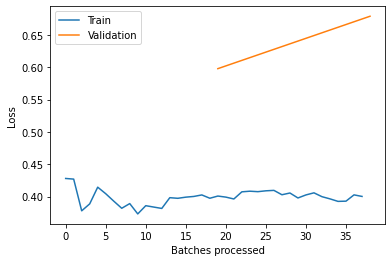

In [20]:
learn_cl.recorder.plot_losses()

In [21]:
learn_cl.show_results()

text,target,prediction
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive,positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative,negative
"xxbos xxmaj how viewers react to this new "" adaption "" of xxmaj shirley xxmaj jackson 's book , which was xxunk as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative,negative
"xxbos xxmaj the trouble with the book , "" xxmaj memoirs of a xxmaj geisha "" is that it had xxmaj japanese xxunk but underneath the xxunk it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by xxunk animals dressed in those xxunk far from xxmaj japanese",negative,positive
"xxbos xxmaj bonanza had a great cast of wonderful actors . xxmaj xxunk xxmaj xxunk , xxmaj pernell xxmaj whitaker , xxmaj michael xxmaj xxunk , xxmaj dan xxmaj blocker , and even xxmaj guy xxmaj williams ( as the cousin who was brought in for several episodes during 1964 to replace xxmaj adam when he was leaving the series ) . xxmaj the cast had chemistry , and they",positive,positive


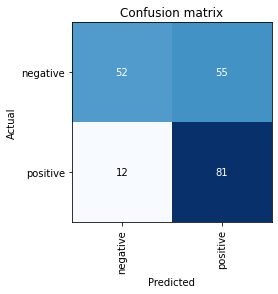

In [22]:
preds, y, losses = learn_cl.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_cl, preds, y, losses)
interp.plot_confusion_matrix()

### Excercise
Make sentiment predictions for 5 movie reviews from IMDB web site.

In [74]:
# A rotten tomatos review for Christopher's Nolan movie Inception
first_movie_review = learn.predict('This endlessly fascinating swirl ', 58)
first_movie_review

'This endlessly fascinating swirl  , but is true to my favorite French western genre , Lead Man . As you can have a longer expect to recommend it . The determination of the other reviews is pretty crisp , and it has something to do with wonderful photography and even an excellent dozen camera work . \n \n '

In [75]:
real_first_movie_review = print('This endlessly fascinating swirl of a film could have come only from Nolan, who blends the cerebral twistiness of Memento (his thriller that moves backward in time) with the spectacular action of his Batman megahit, The Dark Knight')

This endlessly fascinating swirl of a film could have come only from Nolan, who blends the cerebral twistiness of Memento (his thriller that moves backward in time) with the spectacular action of his Batman megahit, The Dark Knight


In [76]:
first_movie_review_classifier = learn_cl.predict(first_movie_review)
print(first_movie_review_classifier[2][0])

tensor(0.0083)


In [77]:
# A quote from The Usual Suspects 
# should have 14 words
second_movie_quote= learn.predict('The greatest trick the Devil ever pulled', 9)
second_movie_quote

"The greatest trick the Devil ever pulled back , Peter Austen 's film identical"

In [78]:
real_second_quote = print("The greatest trick the Devil ever pulled was convincing the world he didn't exist")

The greatest trick the Devil ever pulled was convincing the world he didn't exist


In [79]:
second_movie_review_classifier = learn_cl.predict(second_movie_quote)
print(second_movie_review_classifier[2][0])

tensor(0.0019)


In [80]:
# A quote from V for Vendetta
# should have 24 words 
third_movie_quote = learn.predict('Remember, remember, the fifth,',20)
third_movie_quote

'Remember, remember, the fifth, the last possible word of English , i went down for the first time in English ( the'

In [81]:
real_third_movie_review = print('"Remember, remember, the Fifth of November, the Gunpowder Treason and Plot. I know of no reason why the Gunpowder Treason should ever be forgot..."')

"Remember, remember, the Fifth of November, the Gunpowder Treason and Plot. I know of no reason why the Gunpowder Treason should ever be forgot..."


In [82]:
third_movie_review_classifier = learn_cl.predict(third_movie_quote)
print(third_movie_review_classifier[2][0])

tensor(0.3832)


In [83]:
fourth_movie_review = learn.predict('Nolan masterfully weaves', 28)
fourth_movie_review


'Nolan masterfully weaves in a range of relation suspense between length and humour , but the writing was often less realistic . Made for low - budget , poor acting'

In [90]:
fourth_movie_review_classifier = learn_cl.predict(fourth_movie_review)
print(fourth_movie_review_classifier[2][0])

tensor(0.2738)


In [85]:
real_fourth_review = print('Nolan masterfully weaves all these elements together, creating a second act that is breathtaking, suspenseful and thought-provoking...unfortunately, it takes us a good hour for us to get there.')

Nolan masterfully weaves all these elements together, creating a second act that is breathtaking, suspenseful and thought-provoking...unfortunately, it takes us a good hour for us to get there.


In [86]:
fifth_movie_review = learn.predict('Infused with',27)
fifth_movie_review


'Infused with one of the most popular comments on video ... Screaming Heads is kind of the recording artist Ben Wire temple . He'

In [87]:
real_fifth_movie_review = print('Infused with his trademark wit, the film is hilarious at times but also carries with it more complex undertones. Benjamin is a gorgeous little film.')

Infused with his trademark wit, the film is hilarious at times but also carries with it more complex undertones. Benjamin is a gorgeous little film.


In [88]:
fifth_movie_review_classifier = learn_cl.predict(fifth_movie_review)
print(fifth_movie_review_classifier[2][0])

tensor(0.0023)


In [89]:
learn_cl.data.classes

['negative', 'positive']